In [1]:
import pandas as pd
import numpy as np
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
import sympy as sp
from IPython.display import display, Math, Latex
from shapely.geometry import shape
from shapely.wkt import loads
from scipy.optimize import root_scalar
import mapclassify
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:
labda_optimised = True
labda_y = np.log(1/0.05)/5
run_labda = True

insurance = False

take_up_rate_lb = '55'

save_figures = False
save_file = False

variant = ''
damage_sc = 'extreme'
# _25_damage
# _eta=2
# _discount1%
# _const_v
# _og_damage

folder = 'plots'

In [3]:
if insurance == True:
    insurance_sc = f'uptake{take_up_rate_lb}_insurance'
elif insurance == False and labda_optimised == True:
    insurance_sc = 'no_insurance'
elif labda_optimised == False:
    insurance_sc = 'no_insurance_labda_not_opt'

print(insurance_sc)

no_insurance


### input data

In [4]:
if variant == '':
    Ian_sc = ""
elif variant == '_25_damage':
    Ian_sc = "_25"
elif variant == '_og_damage':
    Ian_sc = "_OG"
    
data_ = pd.read_csv(f'data/census_data_incl{Ian_sc}.csv')
if insurance == True and run_labda == False:
    labda_df = pd.read_csv(f'data/labda_uptake0{take_up_rate_lb}_payout045.csv')
elif insurance == False and run_labda == False:
    labda_df = pd.read_csv(f'data/labda_no_insurance{variant}.csv')

In [5]:
#transform the dataframes into geodataframes
data_copy = data_.copy()
data_copy['geometry'] = data_copy['geometry'].apply(loads)
data_shape = gpd.GeoDataFrame(data_copy, geometry="geometry", crs='EPSG:4326')
data_raw = data_shape

In [6]:
#take only bg's with damage
data = data_raw.loc[data_raw['Damage: Structure'] > 0]
data = data.reset_index(drop=True)

### Parameters

In [7]:
n = 1.5
p = 0.1 # utility discount rate of 10%
deductible = 0.15
frac_payout = 0.45  #from supplymentary information 3.3.1. comaparision with NFIP data p. 11
T = 10 #in years

if take_up_rate_lb == '55':
    take_up_rate = 0.55
elif take_up_rate_lb == '65':
    take_up_rate = 0.65

### pre process data

In [8]:
data['ave_k_str'] = (data['Max Potential Damage: Structure']/data['#_households'])
data['ave_damage'] = (data['Damage: Structure']/data['#_households']) 
data['ave_EAD'] = (data['Risk (EAD)']/data['#_households']) 

In [9]:
data['premium'] = take_up_rate * ((data['ave_EAD'] * (1 -  deductible)))

In [10]:
data['fract_prem_i_0'] = data['premium']/data['ave_i_0']*100

In [11]:
#households will only comply with insurance if this is below 7.5 percent of their yearly income
if insurance == True:
    data['ave_c_0'] = data.apply(lambda row: row['ave_i_0'] - row['premium'] if row['fract_prem_i_0'] < 7.5 else row['ave_i_0'], axis=1)
elif insurance == False:
    data['ave_c_0'] = data['ave_i_0']

In [12]:
data['take_up'] = data.apply(lambda row: True if row['fract_prem_i_0'] < 7.5 else False, axis=1)

In [13]:
(data['take_up'] == False).sum()

2

In [14]:
data['v'] = data['ave_damage'] / data['ave_k_str']
data['v_percen'] = data['v']*100

In [15]:
if variant == '_const_v':
    data['v'] = 0.0605
    data['ave_damage'] = data['v']* data['ave_k_str']

In [16]:
data['index'] = data.index

In [17]:
columns_to_drop = ['Max Potential Damage: Structure','Damage: Structure','Risk (EAD)']
data = data.drop(columns=columns_to_drop)

### Functions

In [18]:
def delta_i(t, labda, v, i_hh):
    return v * i_hh * math.e**(-labda*t)

In [19]:
def delta_i_plot(t, labda, v, i_hh):
    income_l = v * i_hh * math.e**(-labda*t)
    if np.all(t < np.array([0])):
        return i_hh
    else:
        return i_hh-income_l

In [20]:
def c_reco(t, labda, v, k_str):
    return labda * v * k_str * math.e**(-labda * t)

In [21]:
def c_reco_plot(t, labda, v, k_str, i_hh): 
    recovery = labda * v * k_str * math.e**(-labda * t)
    if np.all(t < np.array([0])):
        return i_hh
    else:
        return i_hh-recovery

In [22]:
def delta_c(t, labda, v, k_str, i_hh):
    return  c_reco(t, labda, v, k_str) + delta_i(t, labda, v, i_hh)

In [23]:
# def delta_c_without_premium(t, labda, v, k_str, i_wage):
#     return  c_reco(t, labda, v, k_str) + delta_i(t, labda, v, i_wage)

ASSUMPTION: rate of recovery is derivative of k_t

In [24]:
def find_t_hat(labda, v, k_str, i_hh, damage):
    insurance_payment_amount = damage * frac_payout * take_up_rate
    if v > 0:
        def equation(t_hat):
            integral_result, _ = quad(delta_c, 0, t_hat, args=(labda, v, k_str, i_hh))
            return (integral_result - insurance_payment_amount - delta_c(t_hat, labda, v, k_str, i_hh) * t_hat)

        # Check if the equation has different signs at the bracket endpoints
        lower_bound = 0
        upper_bound = 10
        if equation(lower_bound) * equation(upper_bound) > 0:
            # Adjust the bracket as needed
            lower_bound = 0
            upper_bound = 50
        
        result = root_scalar(equation, bracket=[lower_bound, upper_bound])

        # The root is the value of t_hat
        return result.root
    else:
        return 0

In [25]:
c_negative =[]

def c_t(t, labda, v, k_str, i_hh, c_0, damage, frac_premium_income):
        
    # Calculate consumption using the remaining insurance amount as constant consumption loss
    if insurance == True and frac_premium_income < 7.5:
        T = find_t_hat(labda, v, k_str, i_hh, damage)
        if T > 0: 
            integral_delta_c, error = quad(delta_c, 0, T, args=(labda, v, k_str, i_hh))
            total_consum_loss_t = integral_delta_c
            insurance_payment_amount = damage * frac_payout * take_up_rate
            gamma = (total_consum_loss_t - insurance_payment_amount)/T
        else:
            gamma = 0
                
        c = max(c_0 - delta_c(t, labda, v, k_str, i_hh), c_0 - gamma)
    
    elif insurance == True and frac_premium_income > 7.5:
        c = c_0 - delta_c(t, labda, v, k_str, i_hh)
    
    elif insurance == False:
        c = c_0 - delta_c(t, labda, v, k_str, i_hh)

    if np.all(t < np.array([0])):
        return c_0
    elif np.all(t > np.array([0])):
        if np.all(c < np.array([0])):
            c_negative.append(c)
            return c
        else:
            return c

In [26]:
def u_t(t, labda, v, k_str, i_hh, c_0, damage, frac_premium_income):
    consump = c_t(t, labda, v, k_str, i_hh, c_0, damage, frac_premium_income)
    utility = (consump**(1-n))/(1-n)
    return utility

In [27]:
def delta_U(labda, v, k_str, i_hh, c_0, damage, frac_premium_income):
    def u(t, labda, v, k_str, i_hh, c_0, damage, frac_premium_income):
        u_0 = (c_0**(1-n))/(1-n)
        u_time = u_t(t, labda, v, k_str, i_hh, c_0, damage, frac_premium_income)
        u_loss = (u_0 - u_time) *math.e**(-p*t)
        return u_loss
    integral_U, error = quad(u,0,10,args=(labda, v, k_str, i_hh, c_0, damage, frac_premium_income))
    return integral_U

In [28]:
# def delta_W_fraction(labda, v, k_str, i_wage, c_0, damage, premium, frac_premium_income):
#     u_0 = (c_0**(1-n))/(1-n)
#     def w(t, labda, v, k_str, i_wage, c_0, damage, premium, frac_premium_income):
#         u_time = u_t(t, labda, v, k_str, i_wage, c_0, damage, premium, frac_premium_income)
#         w_t = (u_0 - u_time) *math.e**(-p*t)
#         return w_t
#     integral_W, error = quad(w,0,10,args=(labda, v, k_str, i_wage, c_0, damage, premium, frac_premium_income))
#     return integral_W/-u_0

In [29]:
def objective_function(labda, v, k_str, i_hh, c_0, damage, frac_premium_income):
    integral_value, _ = quad(u_t, 0, 10, args=(labda, v, k_str, i_hh, c_0, damage, frac_premium_income))
    return -integral_value  # Negative since we are using a minimization function

In [30]:
def optimal_labda(v, k_str, i_hh, c_0, damage, frac_premium_income, index):
    # Initial guess for labda
        initial_labda_guess = 0.3

        # Minimize the negative of the objective function to find the maximum
        result = minimize(objective_function, initial_labda_guess, args=(v, k_str, i_hh, c_0, damage, frac_premium_income),method='Nelder-Mead', tol=1e-6, bounds=[(0.3, 140)])

        # Extract the optimal labda value
        optimal_labda = result.x[0]
        print(index,result.message)
        return optimal_labda

#### extra functions for income loss and consumption loss

In [31]:
def total_delta_c(labda, v, k_str, i_hh, T):
    integral_delta_c, error = quad(delta_c, 0, T, args=(labda, v, k_str, i_hh))
    return integral_delta_c

In [32]:
def total_delta_i(labda, v, i_hh, T):
    integral_delta_i, error = quad(delta_i, 0, T, args=(labda, v, i_hh))
    return integral_delta_i

In [33]:
def total_c_reco(labda, v, k_str, T):
    integral_c_reco, error = quad(c_reco, 0, T, args=(labda, v, k_str))
    return integral_c_reco

### Labda optimization

In [34]:
L = []

if run_labda == True:
    for index, row in data.iterrows():
        consumption = row['ave_c_0']
        v = row['v']
        k_str = row['ave_k_str']
        i_hh = row['ave_i_0']
        damage = row['ave_damage']
        frac_premium_income = row['fract_prem_i_0']
        index = row['index']

        results_L = optimal_labda(v, k_str, i_hh, consumption, damage, frac_premium_income, index)

        L.append(results_L)

    L_df = pd.DataFrame(L)

0 Optimization terminated successfully.
1 Optimization terminated successfully.
2 Optimization terminated successfully.
3 Optimization terminated successfully.
4 Optimization terminated successfully.
5 Optimization terminated successfully.
6 Optimization terminated successfully.
7 Optimization terminated successfully.
8 Optimization terminated successfully.
9 Optimization terminated successfully.
10 Optimization terminated successfully.
11 Optimization terminated successfully.
12 Optimization terminated successfully.
13 Optimization terminated successfully.
14 Optimization terminated successfully.
15 Optimization terminated successfully.
16 Optimization terminated successfully.
17 Optimization terminated successfully.
18 Optimization terminated successfully.
19 Optimization terminated successfully.
20 Optimization terminated successfully.
21 Optimization terminated successfully.
22 Optimization terminated successfully.
23 Optimization terminated successfully.
24 Optimization terminated

In [35]:
if labda_optimised == True and run_labda == False:
    print('1')
    data['labda'] = labda_df['labda']
elif labda_optimised == True and run_labda == True:
    print('2')
    data['labda'] = L
elif labda_optimised == False:
    print('3')
    data['labda'] = labda_y

2


In [36]:
if run_labda == True:
    col_df_labda = ['labda', 'GEOID']
    df_labda = data[col_df_labda].copy()
    if insurance == True:
        df_labda.to_csv(f'data/labda_uptake0{take_up_rate}_payout045.csv', index=False)
    elif insurance == False:
        df_labda.to_csv(f'data/labda_no_insurance{variant}.csv')

In [37]:
data['recovery_time'] = np.log(1/0.05)/data['labda']

[]

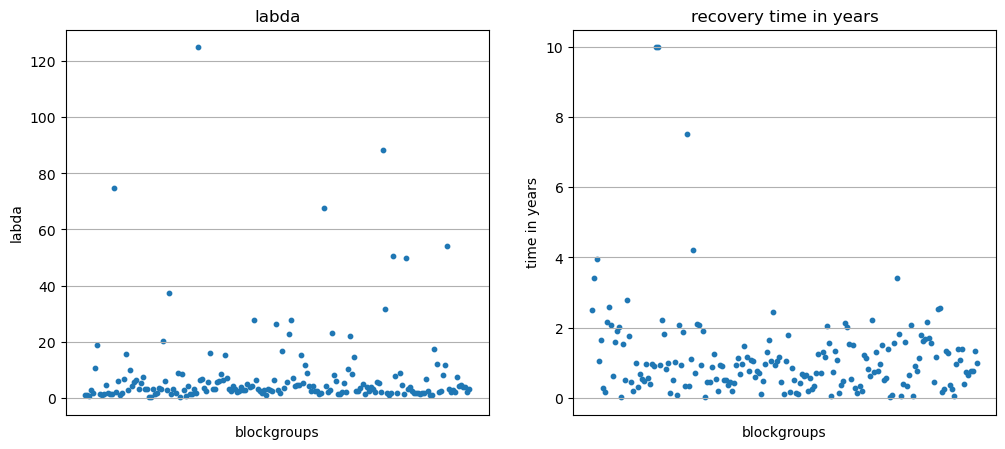

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

axes[0].scatter(data.index, data['labda'], s=10)
axes[0].grid(True)
axes[0].set_title('labda')
axes[0].set_ylabel('labda')
axes[0].set_xlabel('blockgroups')
axes[0].set_xticks([]) 

axes[1].scatter(data.index, data['recovery_time'], s=10)
axes[1].grid(True)
axes[1].set_title('recovery time in years')
axes[1].set_ylabel('time in years')
axes[1].set_xlabel('blockgroups')
axes[1].set_xticks([]) 

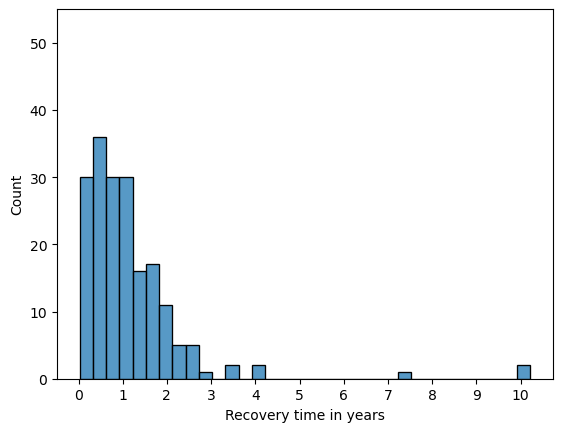

In [39]:
fig = sns.histplot(data=data['recovery_time'], binwidth=0.3)
plt.xlabel('Recovery time in years')
plt.ylim(0, 55)
plt.xticks(np.arange(0, 11, 1))  # Set x-axis ticks from 0 to 10 with step size 1
plt.xticks(np.arange(0, 11, 1))

plt.savefig(f'{folder}/histogram recovery time.jpg', dpi=300, bbox_inches='tight')

### Calculations

#### consumption and utility

In [40]:
# Initialize an empty list to store results
c = []
u = []
reco = []
i = []

times = np.linspace(-2, 10, 400,endpoint=True)

# Iterate over each year from 1 to 10
for year in times:
    c_t_values = []
    u_values = []
    reco_values = []
    i_values = []
    
    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        consumption = row['ave_c_0']
        v = row['v']
        k_str = row['ave_k_str']
        labda = row['labda']
        i_hh = row['ave_i_0']
        damage = row['ave_damage']
        frac_premium_income = row['fract_prem_i_0']
        
        results_c_t = c_t(year, labda, v, k_str, i_hh, consumption, damage, frac_premium_income)
        results_u_t = u_t(year, labda, v, k_str, i_hh, consumption, damage, frac_premium_income)
        results_reco_t = c_reco_plot(year, labda, v, k_str, i_hh)
        results_i_t = delta_i_plot(year, labda, v, i_hh)

        c_t_values.append(results_c_t)
        u_values.append(results_u_t)
        reco_values.append(results_reco_t)
        i_values.append(results_i_t)

#     Append the list of c_t values for the current year to results
    c.append(c_t_values)
    u.append(u_values)
    reco.append(reco_values)
    i.append(i_values)

In [41]:
# Create a new DataFrame from the lists
c_df = pd.DataFrame(c)
u_df = pd.DataFrame(u)
reco_df = pd.DataFrame(reco)
i_df = pd.DataFrame(i)

In [42]:
#create dataset to plot only one bg
c_df.index = times
reco_df.index = times
i_df.index = times

In [43]:
#calcuate the total consumption over all the block groups, needed to create plots
total_c = c_df.T.sum(axis=0)
total_u = u_df.T.sum(axis=0)

c_t_df_total = pd.DataFrame({'c_t':total_c, 'u_t':total_u})

In [44]:
# check for negative values
all_negative_values = c_df[c_df < 0].stack().tolist()
print('number negative values within function c_t:',len(c_negative))
print('negative values in dataset c_df:', all_negative_values)

number negative values within function c_t: 0
negative values in dataset c_df: []


#### Welfare

In [45]:
U = []
# W_fraction =[]
delta_C = []
delta_income = []
C_reco = []

for index, row in data.iterrows():
    consumption = row['ave_c_0']
    v = row['v']
    k_str = row['ave_k_str']
    labda = row['labda']
    i_hh = row['ave_i_0']
    damage = row['ave_damage']
    frac_premium_income = row['fract_prem_i_0']
    
    result_delta_c = total_delta_c(labda, v, k_str, i_hh, T)
    result_delta_i = total_delta_i(labda, v, i_hh, T)
    result_c_reco = total_c_reco(labda, v, k_str, T)
    
    results_U = delta_U(labda, v, k_str, i_hh, consumption, damage, frac_premium_income)
#     results_W_fraction = delta_W_fraction(labda, v, k_str, i_wage, consumption, damage, premium, frac_premium_income)
    
    U.append(results_U)
#     W_fraction.append(results_W_fraction)
    delta_C.append(result_delta_c)
    delta_income.append(result_delta_i)
    C_reco.append(result_c_reco)

In [46]:
results_df = pd.DataFrame({'delta_u':U, 'income_loss':delta_income, 'consump_loss':delta_C, 
                     'recovery_costs':C_reco}) #'W_frac': W_fraction

In [47]:
results_df['owner_households'] = data['owner_households']
results_df['ave_i_0'] = data['ave_i_0']
results_df['ave_c_0'] = data['ave_c_0']
results_df['ave_damage'] = data['ave_damage']
results_df['labda'] = data['labda']
results_df['v'] = data['v']
results_df['premium'] = data['premium']
results_df['fract_prem_i_0'] = data['fract_prem_i_0']
results_df['geometry'] = data['geometry']
results_df['recovery_time'] = data['recovery_time']
results_df['GEOID'] = data['GEOID']
results_df['ave_k_str'] = data['ave_k_str']
results_df['fraction'] = data['fraction']
results_df['v_percen'] = data['v_percen']

In [48]:
# Creating a new DataFrame with repeated rows based on 'owner_households'
data_hh = results_df.loc[results_df.index.repeat(results_df['owner_households'])]

# Resetting index to have a new integer-based index
data_hh.reset_index(drop=True, inplace=True)

In [49]:
c_mean_total = np.mean(data_hh['ave_c_0'])
c_mean_total

131870.89344381535

In [50]:
marginal_ut_ave = c_mean_total**(-n)
marginal_ut_ave

2.0882215683583802e-08

In [51]:
#calculate consumption equavalent
data_hh['wellbeing_loss'] = data_hh['delta_u']/marginal_ut_ave
results_df['wellbeing_loss'] = results_df['delta_u']/marginal_ut_ave

# data_hh['frac_wellbeing_loss'] = data_hh['W_frac']

In [52]:
def quantiles(df):
    q1=df.quantile(0.25)
    q2=df.quantile(0.50)
    q3=df.quantile(0.75)
    return q1,q2,q3

In [53]:
income_quantiles = quantiles(data_hh['ave_i_0'])
income_quantiles

(91653.2894736842, 119410.747185261, 147536.95441319107)

In [54]:
bins = [0, income_quantiles[0], income_quantiles[1], income_quantiles[2], float('inf')]
income_categories = ['low_incomes', 'mid_low_incomes', 'mid_high_incomes', 'high_incomes']

data_hh['Income_Category'] = pd.cut(data_hh['ave_i_0'], bins=bins, labels=income_categories, right=False)
results_df['Income_Category'] = pd.cut(results_df['ave_i_0'], bins=bins, labels=income_categories, right=False)

In [55]:
def redistribute_result(df, result, column):
    result_dict = {}

    df[f'{result}_low_low'] = df[column][df['Income_Category'] == 'low_incomes']
    df[f'{result}_low_high'] = df[column][df['Income_Category'] == 'mid_low_incomes']
    df[f'{result}_high_low'] = df[column][df['Income_Category'] == 'mid_high_incomes']
    df[f'{result}_high_high'] = df[column][df['Income_Category'] == 'high_incomes']
    
    result_dict['low_incomes'] = df[f'{result}_low_low'].mean()
    result_dict['mid_low_incomes'] = df[f'{result}_low_high'].mean()
    result_dict['mid_high_incomes'] = df[f'{result}_high_low'].mean()
    result_dict['high_incomes'] = df[f'{result}_high_high'].mean()
        
    return result_dict

In [56]:
wellbeing_loss = redistribute_result(data_hh, "wellbeing_loss", "wellbeing_loss")
damage = redistribute_result(data_hh, "Damage", "ave_damage")
lab = redistribute_result(data_hh, "labda", "labda")
income = redistribute_result(data_hh, "income", "ave_i_0")
loss_ratio = redistribute_result(data_hh, "loss_ratio", "v")
income_loss = redistribute_result(data_hh, "income_loss", "income_loss")
consump_loss = redistribute_result(data_hh, "consump_loss", "consump_loss")
premium = redistribute_result(data_hh, "premium", "premium")
frac_premium = redistribute_result(data_hh, "frac_premium", "fract_prem_i_0")
recovery_time = redistribute_result(data_hh, "recovery_time", "recovery_time")
recovery_costs = redistribute_result(data_hh, "recovery_costs", "recovery_costs")
k_str = redistribute_result(data_hh, "ave_k_str", "ave_k_str")
# frac_welfare_loss = redistribute_result(data_hh, "frac_welfare_loss", "frac_welfare_loss")
v = redistribute_result(data_hh, "v", "v")
v_percen = redistribute_result(data_hh, "v_percen", "v_percen")

In [57]:
# Create an empty DataFrame with columns
columns = ['low_incomes', 'mid_low_incomes', 'mid_high_incomes', 'high_incomes']
results = pd.DataFrame(columns=columns)

In [58]:
# parameters = [lab, damage, con_eq, frac, owner_cost]
variables = [damage, wellbeing_loss, lab, income, loss_ratio, income_loss, consump_loss, premium,frac_premium,k_str, recovery_time,recovery_costs, v,v_percen]

# Use a loop to update the DataFrame
for var_dict in variables:
    if isinstance(var_dict, dict):
        var_name = next(key for key, value in globals().items() if value is var_dict)
        results.loc[var_name] = [var_dict.get(col, 0) for col in columns]

df_income_quan_T = results.T

In [59]:
df_income_quan_T.head()

,damage,wellbeing_loss,lab,income,loss_ratio,income_loss,consump_loss,premium,frac_premium,k_str,recovery_time,recovery_costs,v,v_percen
low_incomes,6438.722145,21544.216247,7.255220,69794.173029,0.034569,1319.651751,7708.880117,1093.096272,1.329019,180289.019941,0.990762,6389.228366,0.034569,3.456942
mid_low_incomes,9819.080353,19694.321871,16.762022,105420.649673,0.042808,2605.313013,12416.072323,501.291041,0.471304,216619.769477,0.909302,9810.759310,0.042808,4.280808
mid_high_incomes,14602.733438,21520.021562,7.742860,131961.710486,0.055101,4055.576772,18622.209077,1830.909205,1.422393,281394.981379,1.065307,14566.632305,0.055101,5.510075
high_incomes,28824.496138,19920.350279,6.553806,219205.588864,0.067805,9513.308562,38336.472984,1406.674640,0.597739,389406.160451,1.086699,28823.164423,0.067805,6.780467


In [60]:
print('percentage of asset loss of low income:',df_income_quan_T.iloc[0]['damage']/df_income_quan_T['damage'].sum()*100)
print('percentage of asset loss of high income:',df_income_quan_T.iloc[3]['damage']/df_income_quan_T['damage'].sum()*100)

percentage of asset loss of low income: 10.787833936192454
percentage of asset loss of high income: 48.29434639894602


In [61]:
print('percentage of wellbeing loss of low income:',df_income_quan_T.iloc[0]['wellbeing_loss']/df_income_quan_T['wellbeing_loss'].sum()*100)
print('percentage of wellbeing loss of high income:',df_income_quan_T.iloc[3]['wellbeing_loss']/df_income_quan_T['wellbeing_loss'].sum()*100)

percentage of wellbeing loss of low income: 26.05769265373153
percentage of wellbeing loss of high income: 24.09362954706066


In [62]:
print('the wellbeing loss of low-income is',round(df_income_quan_T.iloc[0]['wellbeing_loss']/df_income_quan_T.iloc[0]['damage'],1),'times higher than their asset loss')

the wellbeing loss of low-income is 3.3 times higher than their asset loss


In [63]:
x=(df_income_quan_T.iloc[3]['wellbeing_loss']-df_income_quan_T.iloc[3]['damage'])/df_income_quan_T.iloc[3]['damage']*100
print(x, 'of the well-being loss of the highest income group is asset loss' )

-30.890898548383404 of the well-being loss of the highest income group is asset loss


In [64]:
y=(df_income_quan_T.iloc[0]['wellbeing_loss']-df_income_quan_T.iloc[0]['damage'])/df_income_quan_T.iloc[0]['damage']*100
print(y, 'of the well-being loss of the lowest income group is asset loss' )

234.6039130383428 of the well-being loss of the lowest income group is asset loss


In [65]:
# selection of dataframe is made to find block groups with similar relative asset loss (v) for individual comparison
selected_df = results_df[['v', 'Income_Category','ave_k_str','ave_damage','wellbeing_loss']]
selected_df.sort_values(by='ave_damage', ascending=False).head(5)

,v,Income_Category,ave_k_str,ave_damage,wellbeing_loss
2,0.314345,high_incomes,4.736490e+05,148889.363588,127736.429227
32,0.101389,mid_high_incomes,1.167748e+06,118397.164286,147632.531139
51,0.103893,high_incomes,1.022030e+06,106181.466565,28972.824870
46,0.248319,mid_low_incomes,4.145997e+05,102953.071084,288023.725267
1,0.270373,high_incomes,3.694755e+05,99896.344019,115712.250309


In [66]:
categories = ['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes']

In [67]:
df_income_quan_T['wellbeing_loss_per_loss'] = df_income_quan_T['wellbeing_loss']/df_income_quan_T['damage']*100

In [68]:
df_income_quan_T['recovery_time_per_assetloss']=df_income_quan_T['recovery_time']/(df_income_quan_T['damage'])
df_income_quan_T['recovery_time_per_loss_days']=df_income_quan_T['recovery_time_per_assetloss']*365*100

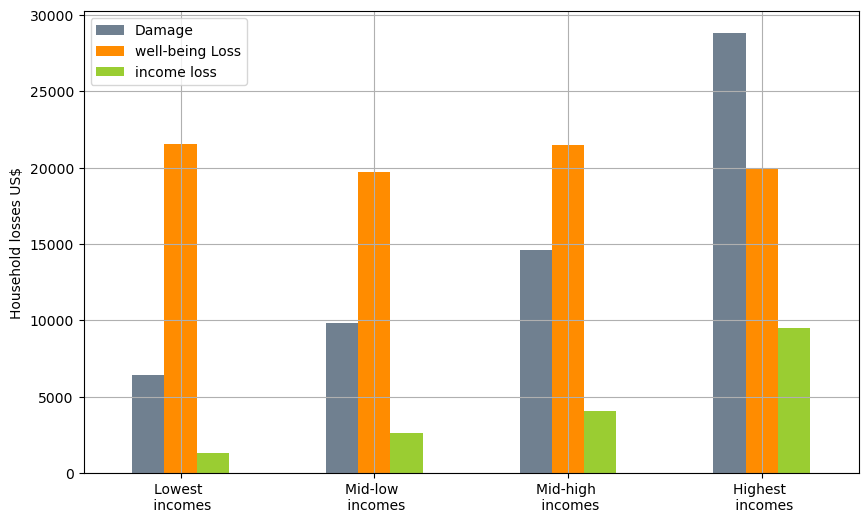

In [69]:
colors = ['slategray', 'darkorange', 'yellowgreen']
custom_cmap = ListedColormap(colors)

ax = df_income_quan_T[[ "damage",'wellbeing_loss','income_loss']].plot(kind='bar', stacked=False, figsize=(10, 6), cmap=custom_cmap)

ax.set_ylabel('Household losses US$')
ax.set_xlabel('')
# ax.set_title(f'Asset, Welfare and income losses per income quantiles')
ax.grid(True) 
# ax.set_ylim(0, 27000)

# Display the legend
ax.legend(['Damage', 'well-being Loss', 'income loss'])
plt.xticks(range(len(categories)), categories, rotation=0)

if save_figures == True:
    print("figure is saved")
    plt.savefig(f'{folder}/quintiles, {damage_sc} event, all losses.png',dpi=500, bbox_inches='tight')

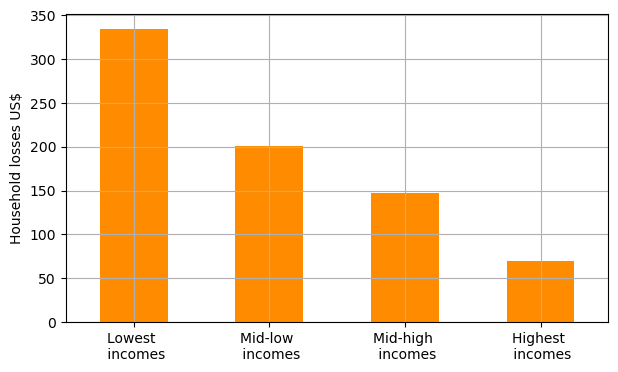

In [70]:
ax = df_income_quan_T['wellbeing_loss_per_loss'].plot(kind='bar', stacked=False, figsize=(7, 4), color='darkorange')

ax.set_ylabel('Household losses US$')
ax.set_xlabel('')
# ax.set_title(f'Household well-being loss per $100 asset loss')
ax.grid(True) 
plt.xticks(range(len(categories)), categories, rotation=0)

if save_figures == True:
    print("figure is saved")
    plt.savefig(f'{folder}/quantiles, extreme event, well-being loss per 100 loss.jpg',dpi=500, bbox_inches='tight')

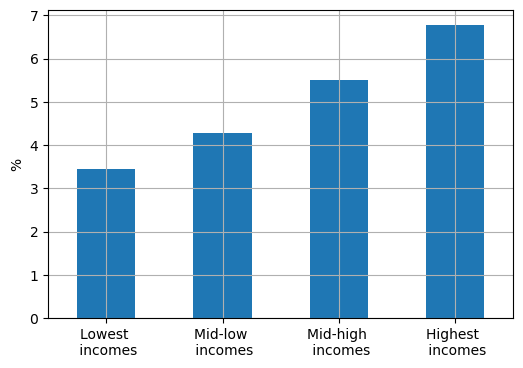

In [71]:
ax = df_income_quan_T['v_percen'].plot(kind='bar', stacked=False, figsize=(6, 4))

ax.set_ylabel('%')
# ax.set_title(f'Average asset loss as a percentage of total assets')
ax.grid(True) 
plt.xticks(range(len(categories)), categories, rotation=0)

if save_figures == True:
    plt.savefig(f'{folder}/quantiles, {damage_sc} event, asset loss in percentage (v).jpg', dpi=300, bbox_inches='tight')
plt.show()

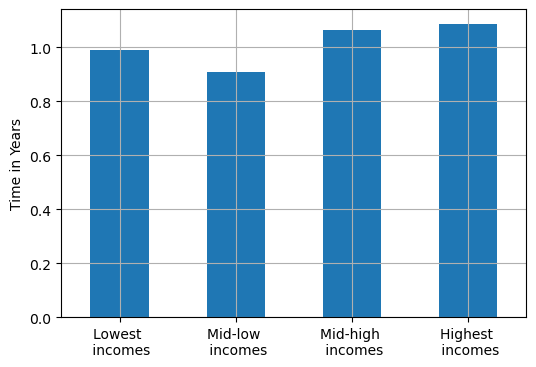

In [72]:
ax1 = df_income_quan_T['recovery_time'].plot(kind='bar', stacked=False, figsize=(6, 4))
ax1.set_ylabel('Time in Years')
# ax1.set_title('Average Recovery Time in Years')
ax1.grid(True)
ax1.set_xticklabels(categories, rotation=0)

if save_figures == True:
    plt.savefig(f'{folder}/quantiles, {damage_sc} event, recovery time years.jpg', dpi=300, bbox_inches='tight')

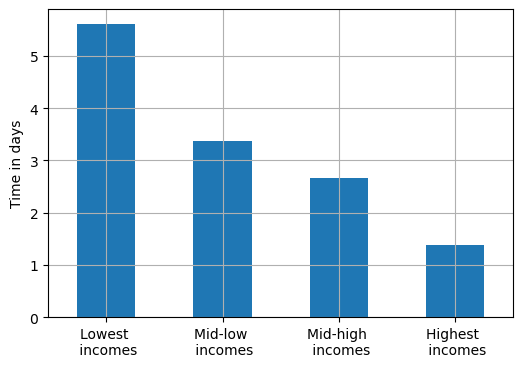

In [73]:
ax2 = df_income_quan_T['recovery_time_per_loss_days'].plot(kind='bar', stacked=False, figsize=(6, 4))
ax2.set_ylabel('Time in days')
# ax2.set_title('Days Recovery per $100 Asset Loss')
ax2.grid(True)
ax2.set_xticklabels(categories, rotation=0)

if save_figures == True:
    plt.savefig(f'{folder}/quantiles, {damage_sc} event, recovery time days per 100 asset loss.jpg', dpi=300, bbox_inches='tight')

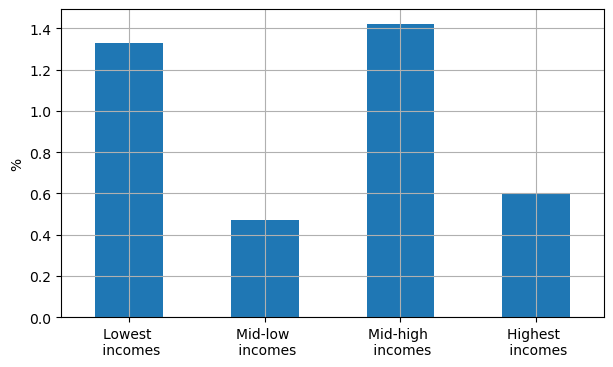

In [74]:
ax = df_income_quan_T['frac_premium'].plot(kind='bar', stacked=False, figsize=(7, 4))

ax.set_ylabel('%')
ax.set_xlabel('')
# ax.set_title(f'premium as a percentage of income')
ax.grid(True) 
plt.xticks(range(len(categories)), categories, rotation=0)

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, premium.png',dpi=500, bbox_inches='tight')

In [75]:
flierprops = dict(marker='o', markerfacecolor='white', markersize=2, linestyle='none')

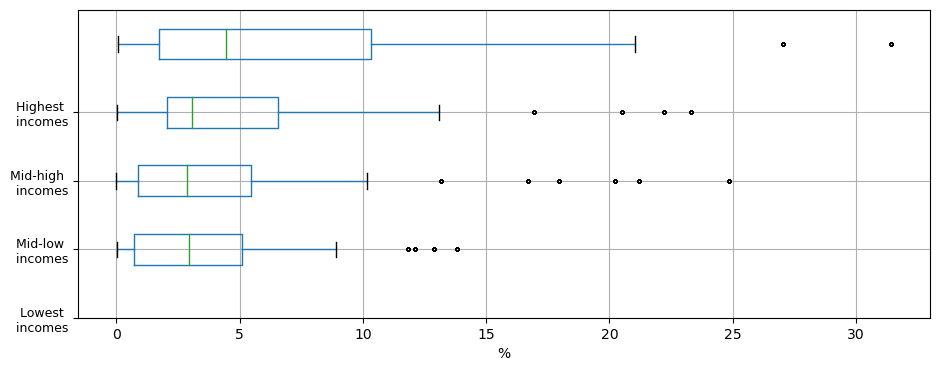

In [76]:
var = 'v_percen'
ax = data_hh.boxplot(column=[f'{var}_low_low', f'{var}_low_high', f'{var}_high_low', f'{var}_high_high'], 
                     figsize=(11, 4), flierprops=flierprops, vert=False)

ax.set_xlabel(f'%')
# ax.set_title(f'Asset loss as a percentage of total assets')
ax.grid(True) 

plt.yticks(range(len(categories)), categories, fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/boxplot asset loss ratio.jpg', dpi=500, bbox_inches='tight')

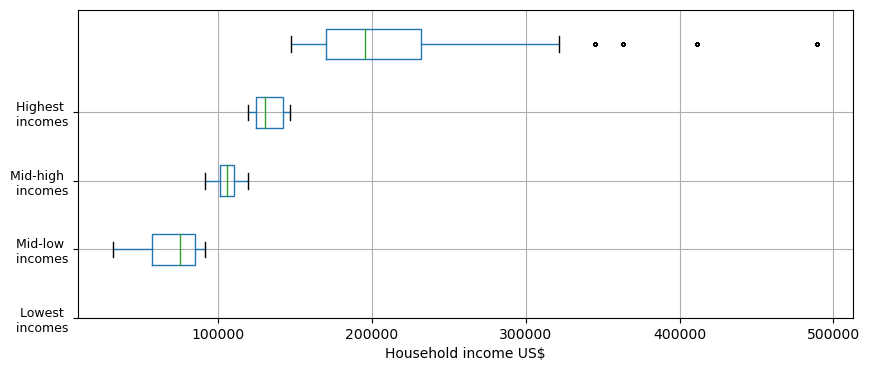

In [77]:
var = 'income'
ax = data_hh.boxplot(column=[f'{var}_low_low', f'{var}_low_high', f'{var}_high_low', f'{var}_high_high'], 
                     figsize=(10, 4), flierprops=flierprops, vert=False)

ax.set_xlabel('Household income US$')
# ax.set_title('Distribution of average yearly household income ($)')
ax.grid(True) 

plt.yticks(range(len(categories)), categories, fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/box plot, income.jpg', dpi=500, bbox_inches='tight')
plt.show()

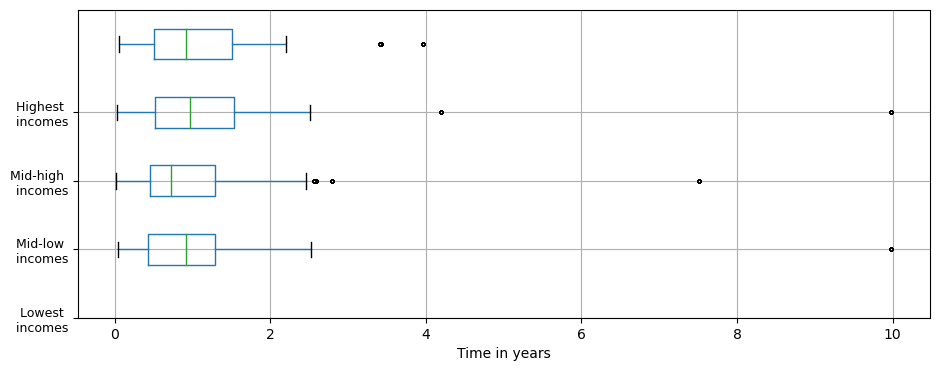

In [78]:
var = 'recovery_time'
ax = data_hh.boxplot(column=[f'{var}_low_low', f'{var}_low_high', f'{var}_high_low', f'{var}_high_high'], 
                     figsize=(11, 4), flierprops=flierprops, vert=False)

ax.set_xlabel(f'Time in years')
# ax.set_title(f'Recovery time in years')
ax.grid(True) 

plt.yticks(range(len(categories)), categories, fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/boxplot, recovery time.jpg', dpi=500, bbox_inches='tight')

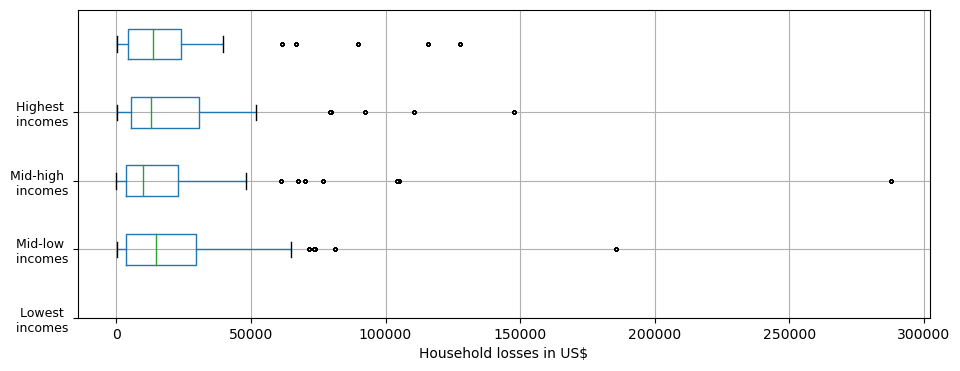

In [79]:
var = 'wellbeing_loss'
ax = data_hh.boxplot(column=[f'{var}_low_low', f'{var}_low_high', f'{var}_high_low', f'{var}_high_high'], 
                     figsize=(11, 4), flierprops=flierprops, vert=False)

ax.set_xlabel('Household losses in US$')
# ax.set_title(f'Distribution of average household well-being loss')
ax.grid(True) 
plt.yticks(range(len(categories)), categories, fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/box plot, well-being loss.jpg', dpi=500, bbox_inches='tight')

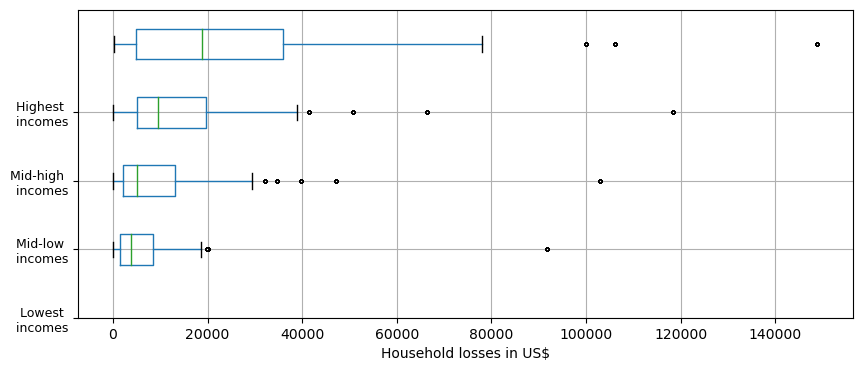

In [80]:
var = 'Damage'
ax = data_hh.boxplot(column=[f'{var}_low_low', f'{var}_low_high', f'{var}_high_low', f'{var}_high_high'], 
                     figsize=(10, 4), flierprops=flierprops, vert=False)

ax.set_xlabel('Household losses in US$')
# ax.set_title('Distribution of average household asset loss')
ax.grid(True) 

plt.yticks(range(len(categories)), categories, fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/box plot, asset loss.jpg', dpi=500, bbox_inches='tight')
plt.show()

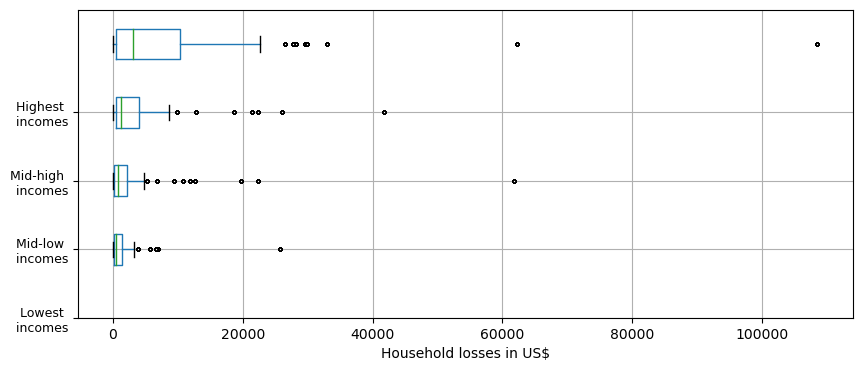

In [81]:
var = 'income_loss'
ax = data_hh.boxplot(column=[f'{var}_low_low', f'{var}_low_high', f'{var}_high_low', f'{var}_high_high'], 
                     figsize=(10, 4), flierprops=flierprops, vert=False)

ax.set_xlabel('Household losses in US$')
# ax.set_title('Distribution of average household income loss')
ax.grid(True) 

plt.yticks(range(len(categories)), categories, fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/box plot, income loss.jpg', dpi=500, bbox_inches='tight')
plt.show()

In [82]:
high_income_data = results_df[results_df['Income_Category'] == 'mid_high_incomes']
# delta_W_df.sort_values(by='welfare_loss',ascending=False).head(6)

## Results

1 rich: k_str= 369476.0
12 poor: k_str= 145389.0
1 rich: welfare loss= 115712.0
12 poor: welfare loss= 71690.0
1 rich: damage= 99896.0
12 poor: damage= 20115.0


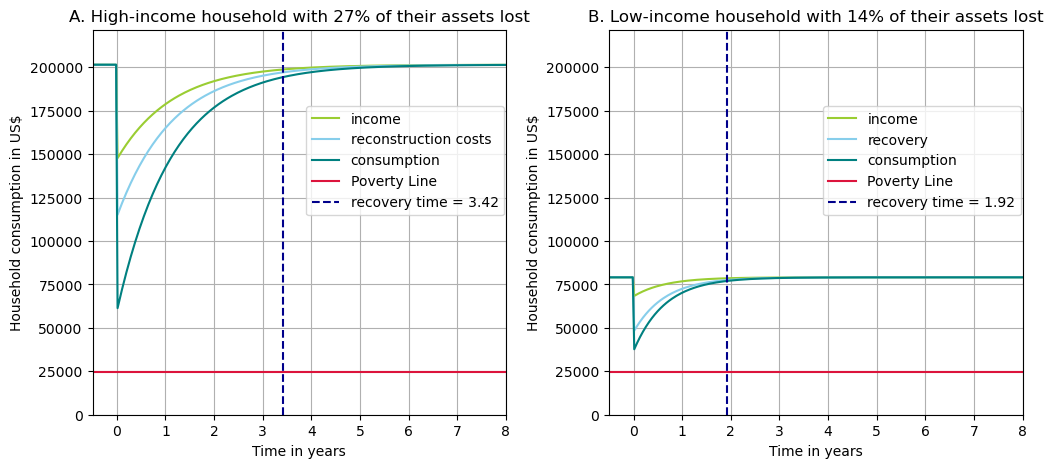

In [83]:
f, ax = plt.subplots(1,2, figsize=(12,5))
poverty_line = 24860 #2023 household of 3 persons, average household size usa is 2.6
f.subplots_adjust(wspace=0.25)

bg_1 = 1 #high income 
bg_2 = 12 #low income
# 160 & 13,  1 en 46midlow, 148 en 12
recovery_time_1 = data.loc[bg_1, 'recovery_time']
recovery_time_2 = data.loc[bg_2, 'recovery_time']
v_1 = int(round(data.loc[bg_1, 'v']*100, 0))
v_2 = int(round(data.loc[bg_2, 'v']*100, 0))

# Plot the function
ax[0].plot(times, i_df[bg_1], label='income', color='yellowgreen')
ax[0].plot(times, reco_df[bg_1], label='reconstruction costs', color='skyblue')
ax[0].plot(times, c_df[bg_1], label='consumption', color='teal')
ax[0].axhline(y=(poverty_line), color='crimson', label='Poverty Line')
ax[0].axvline(x=(recovery_time_1), color='darkblue',linestyle='--', label=f'recovery time = {round(recovery_time_1, 2)}')

ax[1].plot(times, i_df[bg_2], label='income', color='yellowgreen')
ax[1].plot(times, reco_df[bg_2], label='recovery', color='skyblue')
ax[1].plot(times, c_df[bg_2], label='consumption', color='teal')
ax[1].axhline(y=(poverty_line), color='crimson', label='Poverty Line')
ax[1].axvline(x=(recovery_time_2), color='darkblue',linestyle='--', label=f'recovery time = {round(recovery_time_2, 2)}')

for ax_i in ax:
    ax_i.grid(True)
    ax_i.set(xlabel='Time in years', ylabel='Household consumption in US$')
    ax_i.set_xlim(-0.5, 8)
    ax_i.set_ylim(0, (data.loc[bg_1, 'ave_i_0']*1.1))
    ax_i.legend(loc='lower left', bbox_to_anchor=(0.5, 0.5))

ax[0].set_title(f'A. High-income household with {v_1}% of their assets lost')
ax[1].set_title(f'B. Low-income household with {v_2}% of their assets lost')

print(f'{bg_1} rich: k_str=', round(data.loc[bg_1, 'ave_k_str'],0))
print(f'{bg_2} poor: k_str=', round(data.loc[bg_2, 'ave_k_str'],0))
print(f'{bg_1} rich: welfare loss=', round(results_df.loc[bg_1, 'wellbeing_loss'],0))
print(f'{bg_2} poor: welfare loss=', round(results_df.loc[bg_2, 'wellbeing_loss'],0))
print(f'{bg_1} rich: damage=', round(data.loc[bg_1, 'ave_damage'],0))
print(f'{bg_2} poor: damage=', round(data.loc[bg_2, 'ave_damage'],0))

if save_figures == True:
    f.savefig(f'{folder}/line plot, rich poor household consumption {bg_1}_{bg_2}.jpg', dpi=300, bbox_inches='tight')

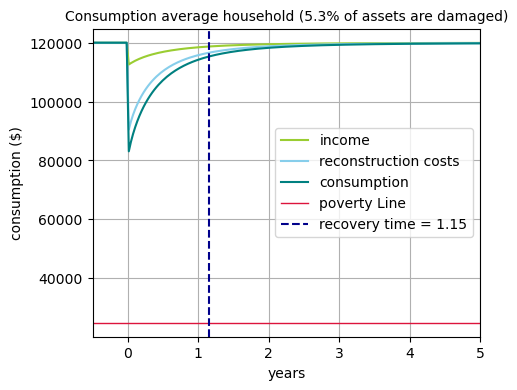

In [84]:
f, ax = plt.subplots(figsize=(5, 4))
 
recovery_time = data['recovery_time'].mean()
v = round(data['v'].mean(), 3)*100

ax.plot(times, i_df.T.mean(), label='income', color='yellowgreen')
ax.plot(times, reco_df.T.mean(), label='reconstruction costs', color='skyblue')
ax.plot(times, c_df.T.mean(), label='consumption', color='teal')
ax.axhline(y=(poverty_line), color='crimson', label='poverty Line',linewidth=1)
ax.axvline(x=(recovery_time), color='darkblue',linestyle='--', label=f'recovery time = {round(recovery_time, 2)}')

ax.set_xlim(-0.5, 5)
ax.grid(True)
ax.legend()
ax.set(xlabel='years', ylabel='consumption ($)')
ax.set_title(f'Consumption average household ({v}% of assets are damaged)',fontsize=10)

# Save the plot if required
if save_figures == True:
    plt.savefig(f'{folder}/average consumption line plot.png', dpi=400, bbox_inches='tight')

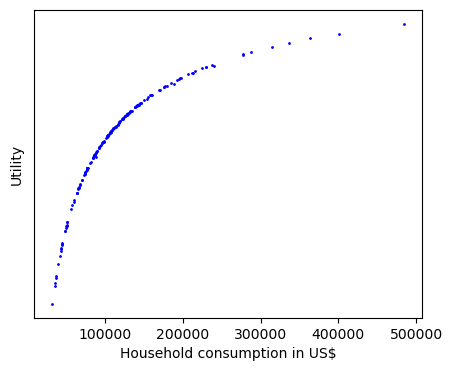

In [85]:
f, ax = plt.subplots(figsize=(5, 4))
ax.scatter(c_df.mean(), u_df.mean(), color='b', s=1)

ax.set_yticks([])
ax.set(xlabel='Household consumption in US$', ylabel='Utility')
# ax.set_title('Consumption versus Utility')

plt.savefig(f'{folder}/utility curve eta={n}.jpg', dpi=300, bbox_inches='tight')

In [86]:
#transform the dataframe into geodataframes
results_df_sh = gpd.GeoDataFrame(results_df, geometry="geometry", crs='EPSG:4326')

### SAVE DF TO RESULTS

In [87]:
if save_file == True:
    results_df_sh.to_csv(f"results/bg_{insurance_sc}{variant}.csv")
    df_income_quan_T.to_csv(f'results/data_quantiles_{insurance_sc}{variant}.csv', index=True)

In [88]:
results_df_sh['index'] = results_df_sh.index
results_df_sh.explore(column='recovery_time',cmap='YlOrBr',style_kwds=dict(color="black"), tooltip=['index','wellbeing_loss', 'v', 'ave_i_0','Income_Category','recovery_time','fract_prem_i_0','fraction'])